In [37]:
import os
import pandas as pd
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn.functional as F
from accelerate import Accelerator
from diffusers import DDPMScheduler, UNet2DConditionModel, AutoencoderKL
from transformers import CLIPTokenizer, CLIPTextModel
from peft import LoraConfig, get_peft_model
from tqdm.auto import tqdm
import gc


In [38]:
def train_lora_model():
    print("--- Initializing Training ---")
    accelerator = Accelerator(gradient_accumulation_steps=1)

    # 1. Load Components
    tokenizer = CLIPTokenizer.from_pretrained(MODEL_NAME, subfolder="tokenizer")
    noise_scheduler = DDPMScheduler.from_pretrained(MODEL_NAME, subfolder="scheduler")
    text_encoder = CLIPTextModel.from_pretrained(MODEL_NAME, subfolder="text_encoder")
    vae = AutoencoderKL.from_pretrained(MODEL_NAME, subfolder="vae")
    unet = UNet2DConditionModel.from_pretrained(MODEL_NAME, subfolder="unet")

    # 2. Freeze parameters
    vae.requires_grad_(False)
    text_encoder.requires_grad_(False)
    unet.requires_grad_(False)

    # 3. Inject LoRA into UNet
    lora_config = LoraConfig(
        r=4,
        lora_alpha=4,
        init_lora_weights="gaussian",
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    )
    unet = get_peft_model(unet, lora_config)

    if accelerator.is_main_process:
        unet.print_trainable_parameters()

    # 4. Dataset & Dataloader
    dataset = DreamBoothTextImgDataset(
        instance_data_root=INSTANCE_DIR,
        instance_prompt_csv=INSTANCE_CSV,
        tokenizer=tokenizer,
        size=RESOLUTION
    )
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    # 5. Optimizer
    optimizer = torch.optim.AdamW(unet.parameters(), lr=LEARNING_RATE)

    # 6. Prepare with Accelerator
    unet, optimizer, dataloader = accelerator.prepare(unet, optimizer, dataloader)

    # Move static models to device
    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16

    text_encoder.to(accelerator.device, dtype=weight_dtype)
    vae.to(accelerator.device, dtype=weight_dtype)

    # 7. Training Loop
    global_step = 0
    progress_bar = tqdm(range(TRAIN_STEPS), disable=not accelerator.is_local_main_process)
    unet.train()

    print("Starting training steps...")

    while global_step < TRAIN_STEPS:
        for batch in dataloader:
            with accelerator.accumulate(unet):
                # Convert images to latent space
                latents = vae.encode(batch["instance_images"].to(dtype=weight_dtype)).latent_dist.sample()
                latents = latents * vae.config.scaling_factor

                # Sample noise
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
                timesteps = timesteps.long()

                # Add noise to latents
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get text embeddings
                encoder_hidden_states = text_encoder(batch["instance_prompt_ids"])[0]

                # Predict noise
                model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                # Compute loss
                target = noise
                loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

                accelerator.backward(loss)
                optimizer.step()
                optimizer.zero_grad()

            if accelerator.sync_gradients:
                global_step += 1
                progress_bar.update(1)

            if global_step >= TRAIN_STEPS:
                break


In [39]:
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
from peft import PeftModel
import torch
import os

# --- Configuration ---
# Must match your training folder
LORA_PATH = "/content/lora_output_nandolal"
BASE_MODEL = "stable-diffusion-v1-5/stable-diffusion-v1-5"

# 1. Load the Base UNet explicitly
print("Loading Base UNet...")
unet = UNet2DConditionModel.from_pretrained(
    BASE_MODEL,
    subfolder="unet",
    torch_dtype=torch.float16
)

# 2. Load the LoRA weights using PEFT (The Critical Fix)
print(f"Loading LoRA weights from {LORA_PATH}...")
try:
    # This matches the 'get_peft_model' logic from your training script
    unet = PeftModel.from_pretrained(unet, LORA_PATH)

    # Merge the weights into the model for faster speed & compatibility
    unet = unet.merge_and_unload()
    print("✅ LoRA weights successfully merged into UNet!")
except Exception as e:
    print(f"❌ Error loading LoRA: {e}")
    # Stop here if weights fail, otherwise you just get generic images again
    raise e

# 3. Create the Pipeline with the Fine-Tuned UNet
pipe = StableDiffusionPipeline.from_pretrained(
    BASE_MODEL,
    unet=unet, # We pass our modified UNet here
    torch_dtype=torch.float16,
    safety_checker=None # Optional: disables safety checker to save memory
).to("cuda")

# 4. Generate Image
# Use a prompt from your CSV 'image_title' column for best results
prompt = "A bird"

print(f"Generating for prompt: {prompt}")
image = pipe(
    prompt,
    num_inference_steps=40,
    guidance_scale=7.5
).images[0]



Loading Base UNet...
Loading LoRA weights from /content/lora_output_nandolal...
✅ LoRA weights successfully merged into UNet!


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Generating for prompt: A bird


  0%|          | 0/40 [00:00<?, ?it/s]


A highly detailed pencil sketch of a family, drawn in the artistic style of Nandalal Bose.
Monochrome graphite lines, hand-drawn texture, soft shading, realistic shadows, no colors.

Generating for prompt: 
A highly detailed pencil sketch of a family, drawn in the artistic style of Nandalal Bose.
Monochrome graphite lines, hand-drawn texture, soft shading, realistic shadows, no colors.



  0%|          | 0/40 [00:00<?, ?it/s]

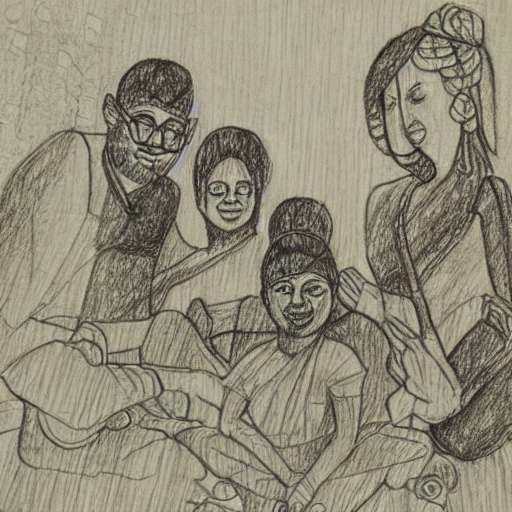

Saved to nandolal_style_result.png


In [40]:
# prompt = "a cow in Nandalal Bose style like pencil sketch"



input_obj = "a family"
prompt = f"""
A highly detailed pencil sketch of {input_obj}, drawn in the artistic style of Nandalal Bose.
Monochrome graphite lines, hand-drawn texture, soft shading, realistic shadows, no colors.
"""
print(prompt)



print(f"Generating for prompt: {prompt}")
image = pipe(
    prompt,
    num_inference_steps=40,
    guidance_scale=7.5
).images[0]

# 5. Save and Display
output_path = "nandolal_style_result.png"
image.save(output_path)
display(image)
print(f"Saved to {output_path}")


A highly detailed pencil sketch of The human, drawn in the artistic style of Nandalal Bose.
Monochrome graphite lines, hand-drawn texture, soft shading, realistic shadows, no colors.

Generating for prompt: 
A highly detailed pencil sketch of The human, drawn in the artistic style of Nandalal Bose.
Monochrome graphite lines, hand-drawn texture, soft shading, realistic shadows, no colors.



  0%|          | 0/40 [00:00<?, ?it/s]

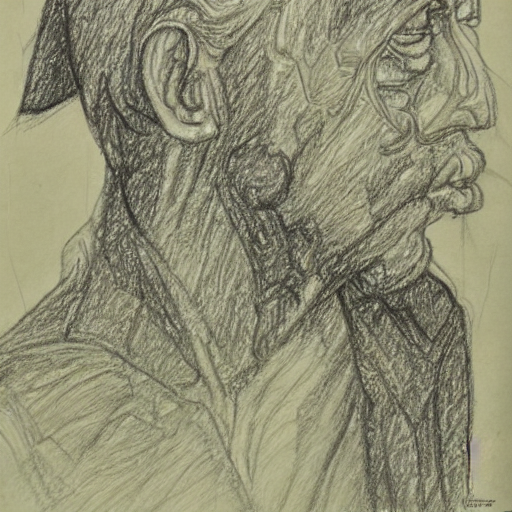

Saved to nandolal_style_result.png


In [48]:
# prompt = "a cow in Nandalal Bose style like pencil sketch"



input_obj = "The human"
prompt = f"""
A highly detailed pencil sketch of {input_obj}, drawn in the artistic style of Nandalal Bose.
Monochrome graphite lines, hand-drawn texture, soft shading, realistic shadows, no colors.
"""
print(prompt)


print(f"Generating for prompt: {prompt}")
image = pipe(
    prompt,
    num_inference_steps=40,
    guidance_scale=7.5
).images[0]


# 5. Save and Display
output_path = "nandolal_style_result.png"
image.save(output_path)
display(image)
print(f"Saved to {output_path}")